#  Исследование закономерностей, определяющих успешность компьютерных игр

Интернет-магазин «Стримчик» продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Чтобы сделать ставку на потенциально популярный продукт и спланировать рекламные кампании необходимо выявить определяющие успешность игры закономерности.

## Импорт библиотек

In [1]:
import pandas as pd
from scipy import stats as st
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

## Изучение данных из файла

In [2]:
# Прочитаем файл games.csv с информацией об играх и сохраним его в переменной data
data = pd.read_csv('/datasets/games.csv')

In [3]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


В таблице 11 столбцов и 16715 записей.

Согласно документации к данным таблица содержит следующие столбцы:

* `Name` — название игры
* `Platform` — платформа
* `Year_of_Release` — год выпуска
* `Genre` — жанр игры
* `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
* `EU_sales` — продажи в Европе (миллионы проданных копий)
* `JP_sales` — продажи в Японии (миллионы проданных копий)
* `Other_sales` — продажи в других странах (миллионы проданных копий)
* `Critic_Score` — оценка критиков (максимум 100)
* `User_Score` — оценка пользователей (максимум 10)
* `Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

### Вывод

Столбцы названы с нарушением стиля - необходимо привести их к нижнему регистру.

Количество значений в столбцах различается. Значит, в данных есть пропущенные значения - в столбцах `Name`, `Year_of_Release`, `Genre`, `Critic_Score`, `User_Score`, `Rating`.

Необходимо заменить тип данных в столбцах `Year_of_Release` и `Critic_Score` c float на int и в столбце `User_Score` с object на float.

Чтобы двигаться дальше, нужно устранить проблемы в данных.

## Предобработка данных

### Переименование столбцов

Переименуем столбцы в соответствии с правилами змеиного стиля - переведем все названия в нижний регистр.

In [5]:
data.columns = data.columns.str.lower()

Проверим названия столбцов.

In [6]:
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Теперь столбцы названы правильно.

### Заполнение пропусков

Количество значений в столбцах различается. Значит, в данных есть пропущенные значения.

In [7]:
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Пропуски есть в столбцах `name`, `year_of_release`, `genre`, `critic_score`, `user_score`, `rating`. Посмотрим, сколько пропусков в процентах.

In [8]:
(data.isna().sum()/data.shape[0]*100).round(1)

name                0.0
platform            0.0
year_of_release     1.6
genre               0.0
na_sales            0.0
eu_sales            0.0
jp_sales            0.0
other_sales         0.0
critic_score       51.3
user_score         40.1
rating             40.5
dtype: float64

Приступим к заполнению пропусков. Рассмотрим пропуски в столбце `name`

In [9]:
data[data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Два пропуска в столбце `name` принадлежат двум старым играм на платформе Sega Mega Drive, она же Sega Genesis, в этих же записях отсутствуют значения в столбце `genre`. Судя по одному году выпуска и записям в столбцах с продажами, это могут быть две записи об одной и той же игре. Скорее всего эти пропуски появились в связи с потерей данных при хранении, либо ошибкой при сборе, так как данные очень старые. В данном случае есть два варианта устранения пропуска - заменить название на 'unknown', либо полностью удалить эти строки, так как игры на платформе Sega Genesis от 1993 года для 2017 года уже не актуальны и не будут использваться при анализе. Выберем удаление.

In [10]:
data.dropna(subset=['name'], inplace=True)
data.reset_index(drop=True, inplace=True)

In [11]:
data[data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


In [12]:
data[data['genre'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


Переходим к следующему столбцу. Изучим пропуски в столбце `year_of_release`.

In [13]:
data['year_of_release'].isna().sum()

269

In [14]:
data[data['year_of_release'].isna()].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN


Можно увидеть, что в названии некоторых игр стоит год - как правило игра выпускается примерно в том же году, который стоит в названии. Можно использовать это для заполнения пропусков.

Если год полностью прописан в названии - ставим его в колонку `year_of_release`.

In [15]:
data[(data['year_of_release'].isna()) & (
    data['name'].str.contains('20\d\d', regex=True))].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
1649,NASCAR Thunder 2003,PS2,NaN,Racing,0.60,0.46,0.00,0.16,84.0,8.7,E
2571,PES 2009: Pro Evolution Soccer,PSP,NaN,Sports,0.04,0.33,0.26,0.17,NaN,NaN,NaN


In [16]:
data['year_of_release'].fillna(data['name'].str.extract(
    r'(20\d\d)', expand=False).astype('float'), inplace=True)

In [17]:
data[(data['year_of_release'].isna()) & (
    data['name'].str.contains('19\d\d', regex=True))]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


Теперь поищем названия, где есть только две последние цифры года.

In [18]:
data[(data['year_of_release'].isna()) & (
    data['name'].str.contains('\s\d\d$', regex=True))]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1300,Triple Play 99,PS,NaN,Sports,0.81,0.55,0.00,0.10,NaN,NaN,NaN
2478,Madden NFL 07,PSP,NaN,Sports,0.77,0.03,0.00,0.04,78.0,6.6,E
2848,Madden NFL 11,Wii,NaN,Sports,0.68,0.00,0.00,0.04,75.0,5.4,E
3412,Madden NFL 06,X360,NaN,Sports,0.54,0.00,0.01,0.03,74.0,4.9,E
4204,Tiger Woods PGA Tour 07,Wii,NaN,Sports,0.43,0.00,0.00,0.04,71.0,6.9,E
7604,Famista 64,N64,NaN,Sports,0.00,0.00,0.17,0.03,NaN,NaN,NaN


Напишем функцию, которая преобразует запись года в полную (четыре цифры).

Выясним максимальный и минимальный год выпуска, чтобы учесть их в функции.

In [19]:
data['year_of_release'].min()

1980.0

In [20]:
data['year_of_release'].max()

2016.0

In [21]:
def std_year(year):
    """
    Функция добавляет к двум последним цифрам года 20 или 19 в зависимости от числа. 
    Если число больше 17 и меньше 80, возвращается NaN, так как данные числа не могут быть годом выпуска."""
    if 0 < int(year) < 17:
        year = '20' + year[1:3]
    elif 80 < int(year) <= 99:
        year = '19' + year[1:3]
    else:
        year = np.nan
    return year

In [22]:
data.loc[(data['year_of_release'].isna()) & (data['name'].str.contains('\s\d\d$', regex=True)), 'year_of_release'] = data[(data['year_of_release'].isna()) & (data['name'].str.contains(
    '\s\d\d$', regex=True))]['year_of_release'].fillna(data[(data['year_of_release'].isna()) & (data['name'].str.contains('\s\d\d$', regex=True))]['name'].str.extract(r'(\s\d\d$)', expand=False).apply(std_year))

In [23]:
data['year_of_release'].isna().sum()

247

Оставшиеся пропуски в этом столбце удалим, так как они составляют всего полтора процента данных, а правильно восстановить данные мы не сможем.

In [24]:
data.dropna(subset=['year_of_release'], inplace=True)
data.reset_index(drop=True, inplace=True)

In [25]:
data['year_of_release'].isna().sum()

0

В столбцах `critic_score`, `user_score` и `rating` пропусков довольно много, но адекватно заполнить их нечем, так как оценка не зависит от имеющихся у нас данных. Скорее всего оценок ставилось мало в ранние годы и это будет не так сильно влиять на анализ данных актуального периода, проверим это предположение.

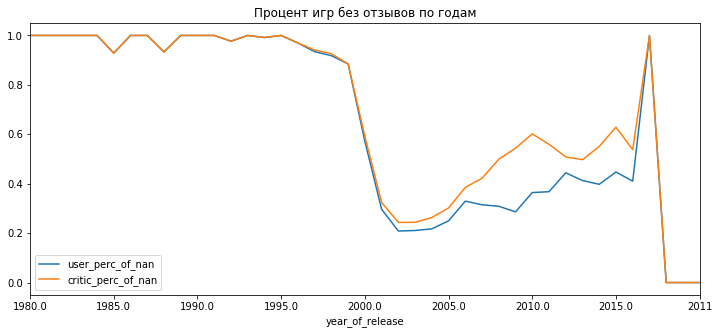

In [26]:
score_nan = data.pivot_table(index='year_of_release',
                             values=['critic_score', 'user_score', 'name'],
                             aggfunc={'name': 'count',
                                      'user_score': lambda x: x.isna().sum(),
                                      'critic_score': lambda x: x.isna().sum()})
score_nan['user_perc_of_nan'] = score_nan['user_score']/score_nan['name']
score_nan['critic_perc_of_nan'] = score_nan['critic_score']/score_nan['name']
score_nan[['user_perc_of_nan', 'critic_perc_of_nan']].plot(title='Процент игр без отзывов по годам',
                                                           figsize=(12, 5))

Действительно, до 2000 года оценки играм почти не ставили ни критики, ни пользователи, а затем количество оценок резко растет, тем не менее даже в последние годы оценки имеют далеко не все игры, а только около 50%.

Отдельно рассмотрим значение 'tbd' в столбце `user_score`. Эта аббревиатура обозначает 'to be determined', то есть рейтинг игре еще не поставлен, по сути для нас - это такое же пропущенное значение, то есть можно заменить его на NaN.

In [27]:
data.loc[data['user_score'] == 'tbd', 'user_score'] = np.nan

Для удобства дальнейшего анализа рейтинга заменим все пропущенные значения на 'unknown'.

In [28]:
data['rating'] = data['rating'].fillna('unknown')

### Изменение типов данных

Теперь ничего не мешает нам заменить тип данных в столбце User_Score с object на float

In [29]:
data['user_score'] = data['user_score'].astype('float')

Также мы можем заменить тип данных в столбце Year_of_Release c float на int

In [30]:
data['year_of_release'] = data['year_of_release'].astype('int')

А вот заменить тип данных в столбце Critic_Score c float на int не удасться, так как в нем остались пропуски.

### Исправление ошибок

Проверим столбец `genre` на единообразие.

In [31]:
sorted(data['genre'].unique())

['Action',
 'Adventure',
 'Fighting',
 'Misc',
 'Platform',
 'Puzzle',
 'Racing',
 'Role-Playing',
 'Shooter',
 'Simulation',
 'Sports',
 'Strategy']

Со значениями в столбце `genre` все в порядке.

Так же проверим столбец `rating`

In [32]:
data['rating'].value_counts()

unknown    6683
E          3934
T          2905
M          1537
E10+       1394
EC            8
K-A           3
RP            1
AO            1
Name: rating, dtype: int64

In [33]:
data['rating'].unique()

array(['E', 'unknown', 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'],
      dtype=object)

Ассоциация ESRB определяет возрастной рейтинг компьютерных игр. Имеется 8 вариантов рейтинга:

* AO ("Adults Only 18+") — «Только для взрослых»: Содержание игры только для взрослых старше 18 лет;
* E ("Everyone") — «Для всех»: Содержание вполне подходит для возрастной категории от 6 лет и старше, такие игры могут понравиться и взрослым;
* E10+ ("Everyone 10 and older") — «Для всех от 10 лет и старше»: Проекты с данным рейтингом могут содержать немного больше мультипликационного или мягкого насилия, или несколько откровенные сцены или минимальное количество крови;
* EC ("Early childhood") — «Для детей младшего возраста»: Игра подходит для детей от 3 лет и старше и не содержит материалов, которые родители могли бы счесть неподходящими;
* K-A ("Kids to Adult") — «От детей до взрослых»: Игры, содержание которых подходит любой аудитории;
* M («Mature») — «Для взрослых»: Материалы игры не подходят для подростков младше 17 лет.
* T («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет и старше.
* RP («Rating Pending») — «Рейтинг ожидается»: Продукт был отправлен в ESRB и ожидает присвоения рейтинга.

Здесь остались пропуски, и некоторые значения встречаются совсем редко. Если сравнить их с системой рейтинга, то станет понятно, что это неявные дубликаты.

Рейтинг 'RP' - rating pending - означает, что рейтинга еще нет и игра ожидает его присвоения. Раз рейтинга нет - логично заменить на 'unknown'.

Рейтинг 'AO' - по сути равен рейтингу M, и то, и то подходит для лиц старше 18.

Рейтинги 'K-A' и 'EC' можно таким же образом включить в рейтинг 'E'.

In [34]:
data.loc[data['rating'] == 'RP', 'rating'] = 'unknown'

In [35]:
data.loc[data['rating'] == 'AO', 'rating'] = 'M'

In [36]:
data.loc[data['rating'] == 'K-A', 'rating'] = 'E'

In [37]:
data.loc[data['rating'] == 'EC', 'rating'] = 'E'

In [38]:
data['rating'].value_counts()

unknown    6684
E          3945
T          2905
M          1538
E10+       1394
Name: rating, dtype: int64

Теперь редких значений нет, пропуски остались, но заменить их мы не можем.

### Удаление дубликатов

Проверим, есть ли в таблице дубликаты

In [39]:
data.duplicated().sum()

0

Полных дубликатов нет.

In [40]:
data[['name', 'platform', 'year_of_release']].duplicated().sum()

1

Мы нашли дубликат, совпадающий по названию игры и платформы и году выпуска. Удалим его.

In [41]:
data[['name', 'platform', 'year_of_release']] = data[['name', 'platform',
                                                      'year_of_release']].drop_duplicates().reset_index(drop=True)

Теперь дубликатов нет.

### Вывод

Мы перевели названия столбцов в нижний регистр, устранили возможные пропуски, изменили тип данных в столбцах `year_of_release` c float на int, `user_score` с object на float и устрнили один дубликат. Мы устранили все возможные пропуски и ошибки в данных, можно переходить к следующему этапу.

## Расчеты

Посчитаем суммарные продажи во всех регионах и запишием их в отдельный столбец.

In [42]:
data['overall_sales'] = data['na_sales'] + \
    data['eu_sales'] + data['jp_sales'] + data['other_sales']

In [43]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,overall_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown,31.38


### Вывод

Необходимые расчеты суммарных продаж сделаны и сохранены в столбец `overall_sales`, можно переходить к анализу данных.

## Анализ данных

### Количество игр, выпущенных в разные годы

С помощью сводной таблицы посчитаем количество игр, выпущеных в разные годы и построим график.

In [44]:
years = data.pivot_table(index='year_of_release',
                         values='name', aggfunc='count')

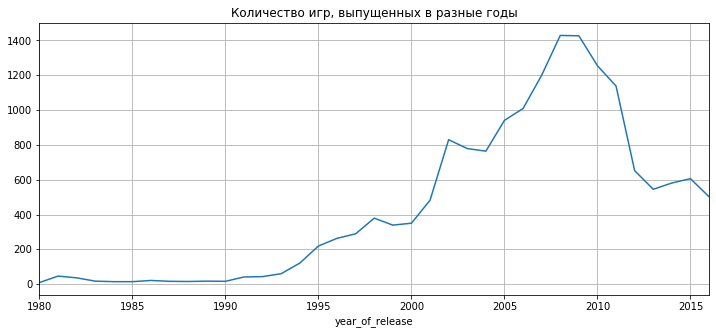

In [45]:
years.plot(kind='line', figsize=(12, 5), grid=True,
           title='Количество игр, выпущенных в разные годы', legend=False)

На графике мы видим, что максимум игр - чуть больше 1400, выпускался в 2008-2009 годах. До 2000 года количество выпущенных игр плавно росло приближаясь к отметке 400 игр в год, затем рост стал более резким, а после достижения максимума в 2009 количество игр начало так же резко снижаться. Возможно при дальнейшем анализе стоит рассматривать именно период после 2009 года, так как явно видно, что в последние годы ситуация на рынке очень отличается от того, что было до этого года.

### Продажи игр, выпущенных на разных платформах

Посмотрим, как менялись продажи по платформам. Выберем платформы с наибольшими суммарными продажами и построим распределение по годам. Вычислим, за какой характерный срок появляются новые и исчезают старые платформы.

In [46]:
platforms = data.pivot_table(index='platform',
                             values='overall_sales',
                             aggfunc='sum').sort_values(by='overall_sales',
                                                        ascending=False)

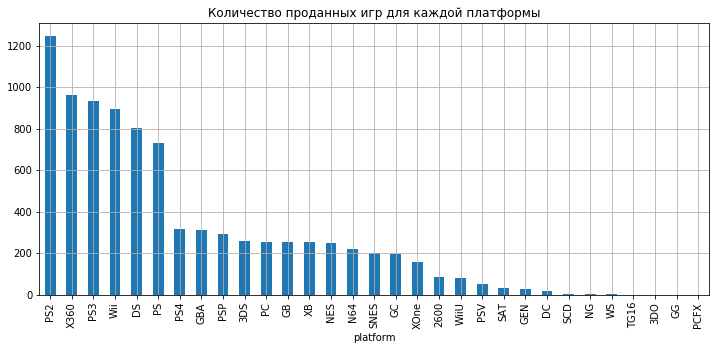

In [47]:
platforms.plot(kind='bar', figsize=(12, 5),
               grid=True, title='Количество проданных игр для каждой платформы', legend=False)

Мы построили график количества проданых игр для каждой платформы, лидером с большим отрывом стала PlayStation 2. Отберем первые шесть платформ для оценки распределения по годам.

In [48]:
years_of_pop_platforms = data[data['platform'].isin(list(platforms.head(6).index))].pivot_table(columns='platform',
                                                                                                index='year_of_release',
                                                                                                values='overall_sales',
                                                                                                aggfunc='sum')

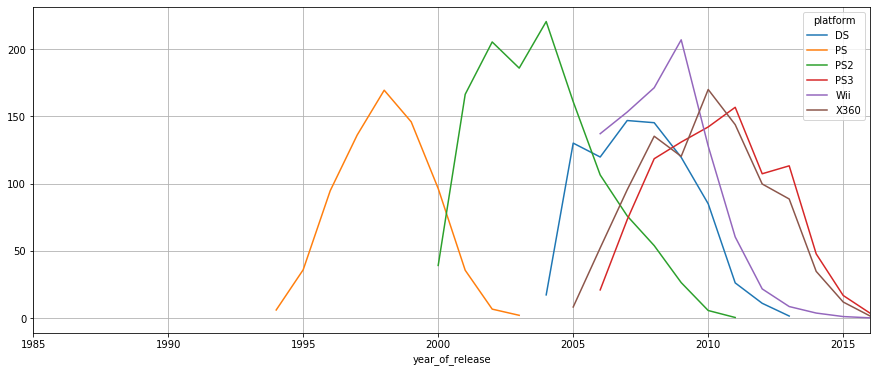

In [49]:
years_of_pop_platforms.plot(kind='line', figsize=(15, 6), grid=True)

На графике мы видим, что платформы переживают резкий всплеск популярности, а затем уходят с рынка. В среднем это происходит за период около 10 лет.

Посчитаем точнее.

In [50]:
years_of_pop_platforms.count().median()

11.0

Уточненное характерное значение пребывания одной платформы на рынке - 11 лет.

Таким образом предложенное ранее значение актуального периода после 2009 года стоит немного скорректировать до 2013, так как тогда в анализе мы практически не будем учитывать платформы, прошедшие пик популярности к настоящему времени.

### Анализ данных за актуальный период

Изучим, какие платформы лидируют по продажам, растут или падают. Выберем несколько потенциально прибыльных платформ.

Приняв во внимание результаты анализа двух предыдущих подразделов, примем за актуальный период с 2013 года. 

In [51]:
data_act = data[data['year_of_release'] >= 2013]

Посмотрим, как в целом вели себя продажи за эти годы.

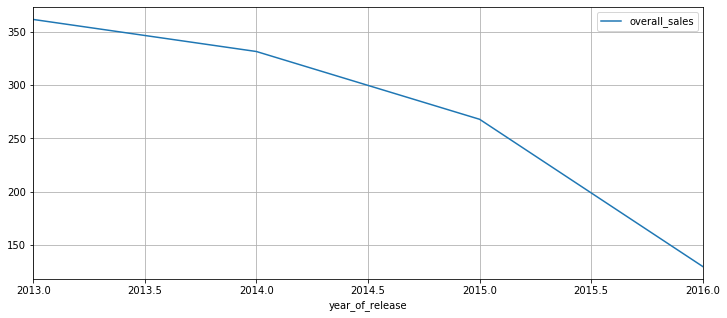

In [52]:
years_act = data_act.pivot_table(
    index='year_of_release', values='overall_sales', aggfunc='sum')
years_act.plot(kind='line', figsize=(12, 5), grid=True)

На графике мы видим общее очень сильное падение количества проданых игр за актуальный период.

Посмотрим, касается ли это всех платформ или какая-то из них удерживает популярность.

Сначала посмотрим, игр на каких платформах суммарно было продано больше всего.

In [53]:
platforms_act = data_act.pivot_table(index='platform',
                                     values='overall_sales',
                                     aggfunc='sum').sort_values(by='overall_sales',
                                                                ascending=False)

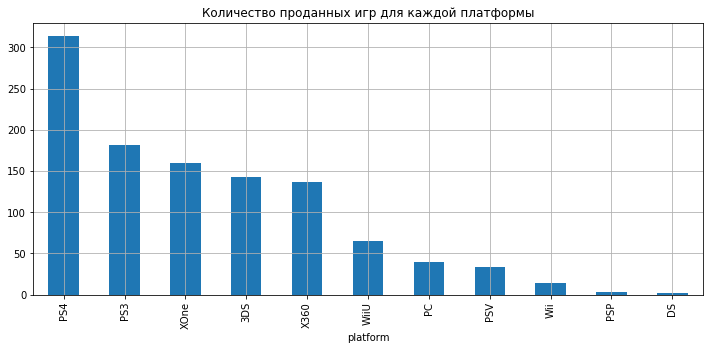

In [54]:
platforms_act.plot(kind='bar', figsize=(12, 5),
                   grid=True, title='Количество проданных игр для каждой платформы', legend=False)

Самыми популярными суммарно за последние несколько лет оказались PlayStation 4, PlayStation 3, Xbox One, Nintendo 3DS и Xbox 360.

Изучим, как изменялось количество выпущенных игр на каждой платформе по годам.

In [55]:
years_of_act_platforms = data_act.pivot_table(columns='platform',
                                              index='year_of_release',
                                              values='name',
                                              aggfunc='count')
years_of_act_platforms

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,
2013.0,91.0,8.0,39.0,126.0,16.0,54.0,63.0,12.0,42.0,75.0,19.0
2014.0,80.0,NaN,47.0,108.0,75.0,10.0,100.0,6.0,31.0,63.0,61.0
2015.0,86.0,NaN,50.0,73.0,137.0,3.0,110.0,4.0,28.0,35.0,80.0
2016.0,46.0,NaN,54.0,38.0,164.0,NaN,85.0,1.0,14.0,13.0,87.0


Данные о платформах Nintendo DS и PSP стоит удалить из таблицы, так как платформы уже не акуальны и мы видим только кусочки данных о них за последние годы. В анализе они участвовать не будут.

In [56]:
data_act = data_act.drop(data_act[(data_act['platform'] == 'DS') | (
    data_act['platform'] == 'PSP')].index)

In [57]:
years_of_act_platforms = data_act.pivot_table(columns='platform',
                                              index='year_of_release',
                                              values='name',
                                              aggfunc='count')

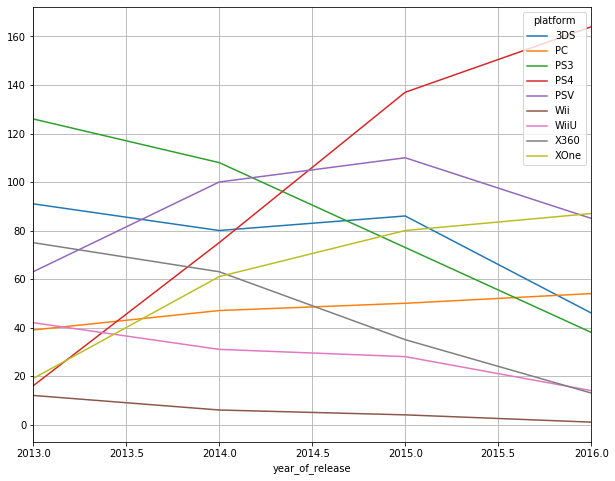

In [58]:
years_of_act_platforms.plot(kind='line', figsize=(10, 8), grid=True)

На графике актуального периода мы видим две платформы, появившиеся в 2013 году и ко времени анализа выпускающие наибольшее количество игр, это PlayStation 4 (PS4) и Xbox One (XOne). Довольно популярная, хотя и уже проходящая пик платформа - PlayStation Vita (PSV). Платформа, стабильно привлекающая пользователей, хотя по их количеству не приближающаяся к лидерам - PC, в последние 3 года также показывает небольшой рост количества выпущенных игр.

Теперь посмотрим данные по продажам.

In [59]:
years_of_act_platforms_sales = data_act.pivot_table(columns='platform',
                                                    index='year_of_release',
                                                    values='overall_sales',
                                                    aggfunc='sum')

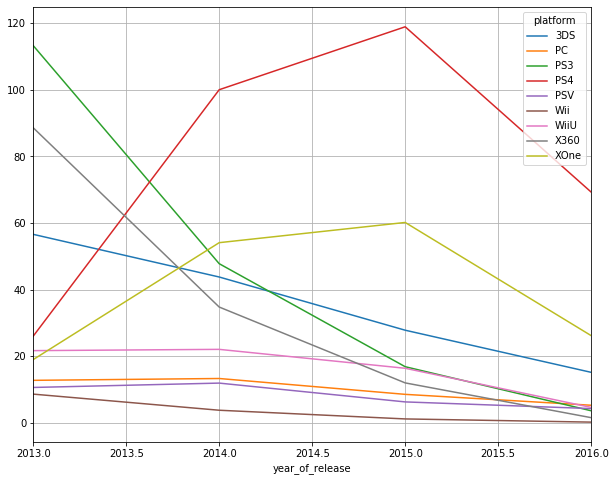

In [60]:
years_of_act_platforms_sales.plot(kind='line', figsize=(10, 8), grid=True)

На графике продаж мы видим неожиданные данные, что две наиболее популярные по количеству игр платформы, находящиеся сейчас в тренде, по количеству продаж показывают резкое падение к 2016 году. Это не согласуется с вычисленным нами средним периодом жизни платформы, который составляет 11 лет, здесь же характерная дуга образовалась за три года. Возможно это связано с некорректными данными по продажам за 2016 год - в описании проекта сказано, что анализ проводится в декабре 2016 года - возможно не учтены данные за последние месяцы. Если учитывать это несоответствие, то платформы PlayStation 4 (PS4) и Xbox One (XOne) выглядят наиболее перспективными. Платформа, находящаяся на 3 месте по количесву продаж на 2016 год - Nintendo 3DS.

Теперь рассмотрим средние продажи по каждой платформе.

In [61]:
years_of_act_platforms_sales_mean = data_act.pivot_table(columns='platform',
                                                         index='year_of_release',
                                                         values='overall_sales',
                                                         aggfunc='mean')

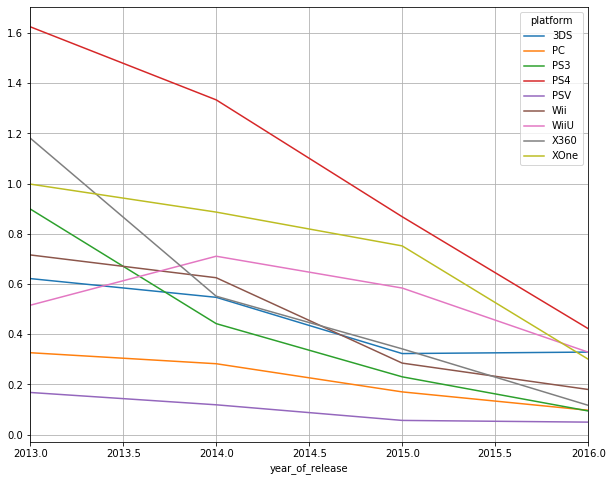

In [62]:
years_of_act_platforms_sales_mean.plot(kind='line', figsize=(10, 8), grid=True)

Рассматривая этот график также будем делать поправку на то, что данные за 2016 год неполные. Четыре лидирующиие платформы по средней прибыли - PlayStation 4 (PS4), Xbox One (XOne), Wii U (WiiU) и Nintendo 3DS. Первые две также входят в пятерку лидеров по количеству выпущенных игр, а вот на платформе Wii U игр выходит не так много, но зато они приносят значительную прибыль. Платформа Nintendo 3DS хотя и приносит значительную прибыль, но по количеству игр показывает падение, а значит уже проходит пик популярности.

Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам.

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


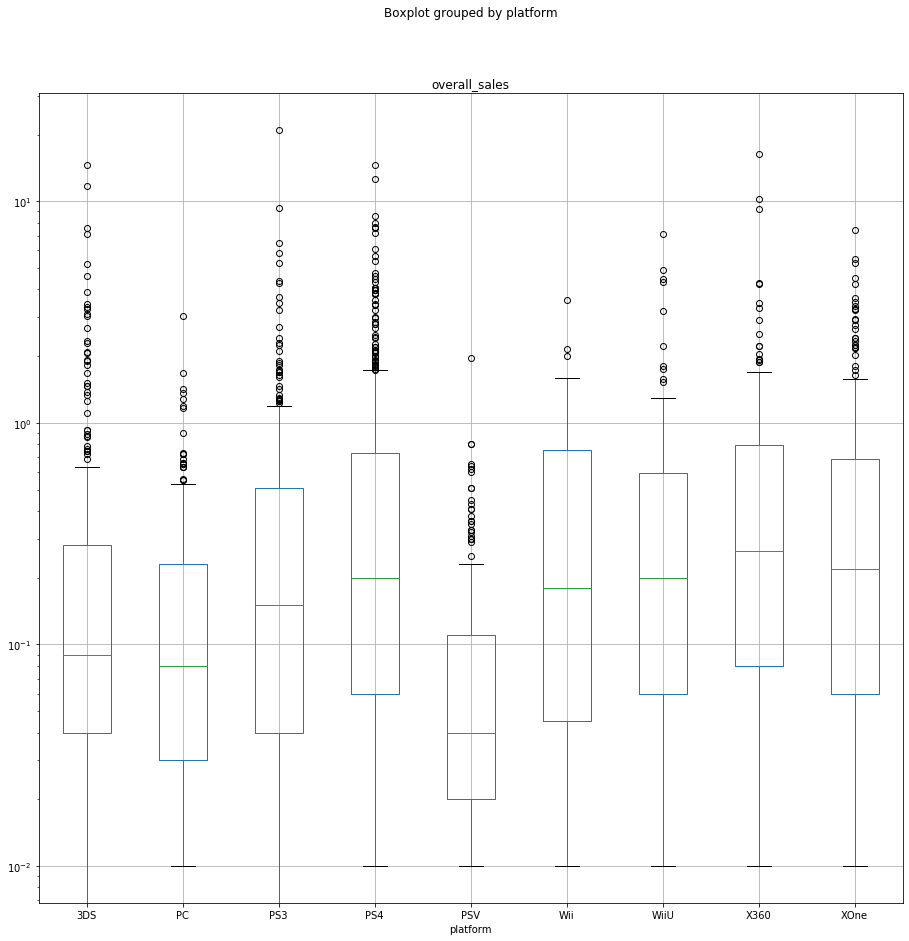

In [63]:
data_act.boxplot('overall_sales', by='platform', figsize=(15, 15))
plt.yscale("log")

На графике мы видим, что игры на платформах PlayStation 4 (PS4), Xbox One (XOne), Wii U (WiiU) в среднем имеют сходные продажи, но на платформах PlayStation 4 и Xbox One гораздо больше 'выбросов' - игр, которые продаются гораздо лучше, чем игра на платформе в среднем, 'бестселлеров'. Игры на платформе Nintendo 3DS в среднем продаются хуже первых трех, но выбросов здесь тоже много, значит много выдающихся игр, которые приносят хорошую прибыль.

### Влияние отзывов

Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами. Для анализа возьмем платформу PlayStation 3, у нее достаточно большие продажи и к моменту анализа она еще не совсем устарела.

In [64]:
data[data['platform'] == 'PS3']['overall_sales'].corr(
    data[data['platform'] == 'PS3']['critic_score'])

0.42917277474201615

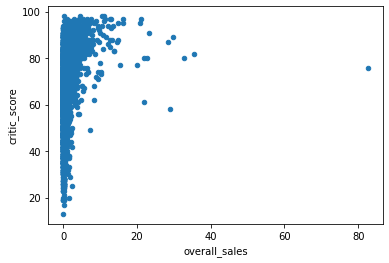

In [65]:
data.plot.scatter(x='overall_sales', y='critic_score')

In [66]:
data[data['platform'] == 'PS3']['overall_sales'].corr(
    data[data['platform'] == 'PS3']['user_score'])

0.12499169862908313

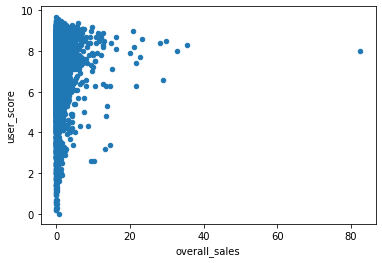

In [67]:
data.plot.scatter(x='overall_sales', y='user_score')

Мы видим, что между отзывами и продажами есть позитивная корреляция. Отзывы критиков оказывают слабое влияние на продажи, а вот отзывы пользователей практически никакого. Возможно это связано с тем, что отзывы критиков выходят раньше отзывов пользователей, и иногда даже раньше официального выпуска игры и имеют больший авторитет.

Посмотрим, сохраняется ли эта корреляция на других платформах в актуальном периоде.

In [68]:
data_act['overall_sales'].corr(data_act['critic_score'])

0.3111300700116905

In [69]:
data_act['overall_sales'].corr(data_act['user_score'])

-0.00877624870930554

Корелляция между продажами и отзывами критиков в целом оказалась лишь немногим слабее, чем по одной платформе. А вот отзывы пользователей на продажи совсем не влияют.

### Распределение по жанрам

Посмотрим на общее распределение игр по жанрам. Выделим жанры с высокими и низкими продажами и найдем самые прибыльные жанры.

Сначала посмотрим распределение по жанрам выпущеных игр.

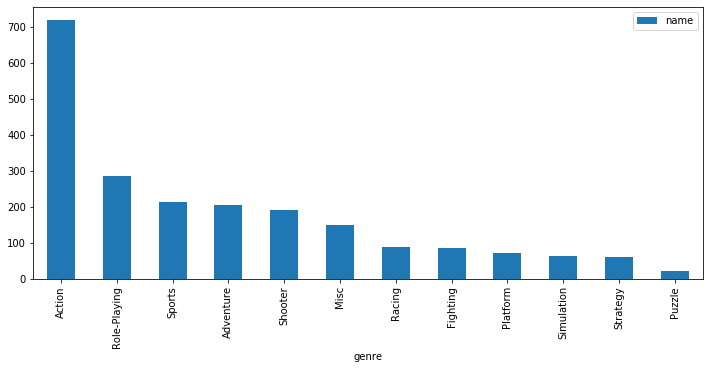

In [70]:
genres_games = data_act.pivot_table(index='genre',
                                    values='name',
                                    aggfunc='count').sort_values(by='name',
                                                                 ascending=False)
genres_games.plot(kind='bar', figsize=(12, 5))

С огромным отрывом лидирует жанр Action, игр этого жанра было выпущено почти в три раза больше, чем следующего по количеству - Role-Playing. А игр в жанре Puzzle выпускают меньше всего.

Посмотрим, как распределяются жанры по прибыльности. Для этого посмотрим среднюю прибыль от игры в каждом жанре.

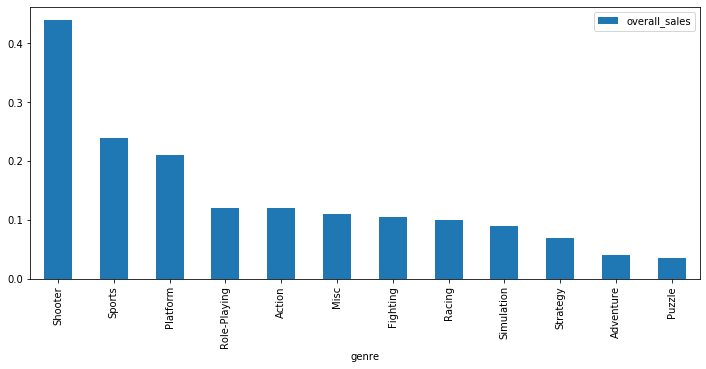

In [71]:
genres_sales = data_act.pivot_table(index='genre',
                                    values='overall_sales',
                                    aggfunc='median').sort_values(by='overall_sales',
                                                                  ascending=False)
genres_sales.plot(kind='bar', figsize=(12, 5))

Самым прибыльным жанром является Shooter, но по количеству игр он всего на пятом месте, это повод обратить внимание на игры именно этого жанра. Игры в жанре Sports прибыльны, но и по количеству на третьем месте. Платформеры на третьем месте по продажам и на девятом по количеству - это тоже перспективный жанр. На предпоследнем месте по прибыльности жанр Adventure, но по количеству игр он четвертый. На этот жанр делать ставку не стоит. И последний и по продажам, и по количеству выпускаемых игр - жанр Puzzle также не очень интересен.

### Вывод

До 2009 года количество ежегодно выпускаемых игр росло, но к моменту анализа упало больше чем в два раза по сравнению с максимумом.
Самой популярной платформой за все время анализа стала PlayStation 2.
Для шести самых популярных платформ мы составили графики продаж и выяснили, что в среднем платформа появляется, проходит пик популярности и уходит с рынка за 11 лет.
Актуальный период для нашего анализа был выбран с 2013 года по настоящее время. Общие продажи игр за это время упали больше чем в два раза. Наибольшее количество игр было продано на платформах PlayStation 4, PlayStation 3, Xbox One, Nintendo 3DS и Xbox 360. Изучив график продаж по годам, наиболее перспективными мы признали платформы PlayStation 4 и Xbox One. Во-вторую очередь возможно обратить внимание на платформы Wii U, игр на ней выпускается не так много, но в пересчете на игру прибыль у них одна из наивысших, и Nintendo 3DS.

## Составление портрета пользователя

Определим для пользователя каждого региона самые популярные платформы и жанры. Проверим, влияет ли рейтинг ESRB на продажи в отдельном регионе.


### Предпочитаемые жанры

Посмотрим, какие жанры игр популярны в каждом регионе. Чтобы сравнение было корректным, считать будем долю продаж каждого жанра от общего числа продаж в регионе.

In [72]:
genres_by_region = data_act.pivot_table(index='genre',
                                        values=['na_sales',
                                                'eu_sales', 'jp_sales'],
                                        aggfunc='sum').sort_values(by='na_sales',
                                                                      ascending=False)
genres_by_region.loc[:, :] = genres_by_region.loc[:, :] / \
    genres_by_region.sum()

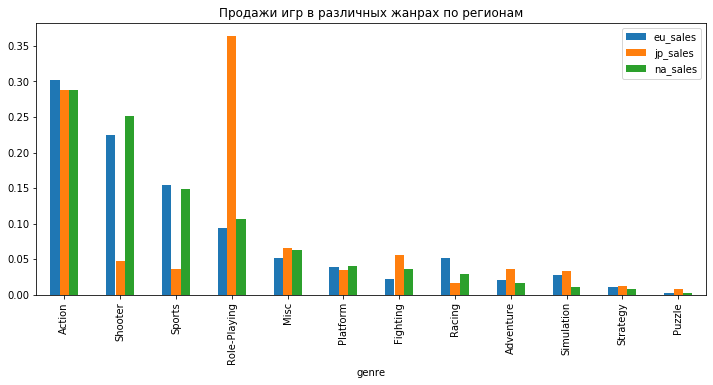

In [73]:
genres_by_region.plot(kind='bar', figsize=(
    12, 5), title='Продажи игр в различных жанрах по регионам')

На графике мы видим, что популярность различных жанров среди пользователей трех регионов - Европы, Японии и Северной Америки, довольно сильно различается, причем в Европе и Америке вкусы более сходны.

Определим топ-5 популярных жанров для каждого региона.

Северная Америка

In [74]:
genres_by_region['na_sales'].sort_values(ascending=False).head()

genre
Action          0.287700
Shooter         0.250983
Sports          0.149314
Role-Playing    0.106104
Misc            0.062780
Name: na_sales, dtype: float64

Европа

In [75]:
genres_by_region['eu_sales'].sort_values(ascending=False).head()

genre
Action          0.301449
Shooter         0.224553
Sports          0.154200
Role-Playing    0.094529
Racing          0.051545
Name: eu_sales, dtype: float64

Япония

In [76]:
genres_by_region['jp_sales'].sort_values(ascending=False).head()

genre
Role-Playing    0.363848
Action          0.287658
Misc            0.065929
Fighting        0.055814
Shooter         0.048028
Name: jp_sales, dtype: float64

Топ-5 жанров в Европе и Северной Америке практически идентичны, оба топа возглавляет жанр экшен, затем идут шутеры спортивные игры и ролевые, однако в Европе на пятом месте оказываются гонки, а в Америке игры смешанного жанра.
В Японии топ совсем другой - на первом месте ролевые игры, затем экшн, смешанный жанр, шутеры и на последнем месте - платформеры.

### Популярные платформы

Рассмотрим распределение платформ по популярности в каждом регионе.

In [77]:
platforms_by_region = data_act.pivot_table(index='platform',
                                           values=['na_sales',
                                                   'eu_sales', 'jp_sales'],
                                           aggfunc='sum').sort_values(by='na_sales',
                                                                         ascending=False)
platforms_by_region.loc[:, :] = platforms_by_region.loc[:,
                                                        :] / platforms_by_region.sum()

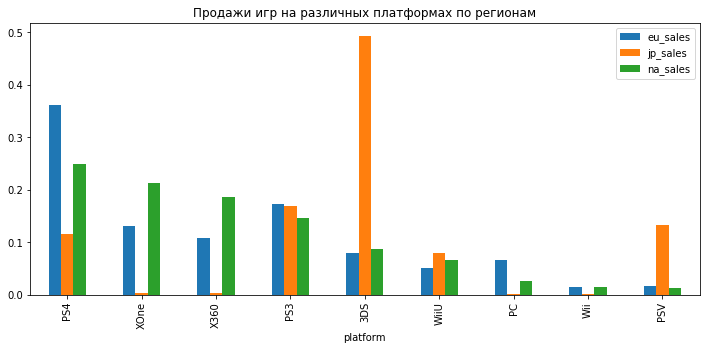

In [78]:
platforms_by_region.plot(kind='bar', figsize=(
    12, 5), title='Продажи игр на различных платформах по регионам')

Платформы, популярные в разных регионах также различны, в Японии подавляющую долю рынка занимает Nintendo 3DS, также популярны платформы семейства PlayStation, тогда как в Европе и Америке большую долю рынка занимают также платформы семейства Xbox.

Определим топ-5 самых популярных и платформ для каждого региона.

Северная Америка

In [79]:
platforms_by_region['na_sales'].sort_values(ascending=False).head()

platform
PS4     0.248560
XOne    0.212803
X360    0.186717
PS3     0.145245
3DS     0.087380
Name: na_sales, dtype: float64

Европа

In [80]:
platforms_by_region['eu_sales'].sort_values(ascending=False).head()

platform
PS4     0.360584
PS3     0.173264
XOne    0.131609
X360    0.108635
3DS     0.079093
Name: eu_sales, dtype: float64

Япония

In [81]:
platforms_by_region['jp_sales'].sort_values(ascending=False).head()

platform
3DS     0.493305
PS3     0.169699
PSV     0.133605
PS4     0.116213
WiiU    0.079173
Name: jp_sales, dtype: float64

Платформы в разных регионах популярны довольно разные, однако везде в топ входит PS3 и PS4 и Nintendo 3DS. Xbox 360, возглавляющий топ в Америке, в Европе находится на 3 месте, а в Японии вообще не входит в топ. Xbox One есть в топе только в Америке на 4 месте. В Европе также на 5 месте стоит PC, которого нет в топах других  стран, а в Японии на 3 месте PS Vita и Wii U, которыех нет в других странах.

### Влияние рейтинга

Ассоциация ESRB определяет возрастной рейтинг компьютерных игр. Имеется 8 вариантов рейтинга:

* AO ("Adults Only 18+") — «Только для взрослых»: Содержание игры только для взрослых старше 18 лет;
* E ("Everyone") — «Для всех»: Содержание вполне подходит для возрастной категории от 6 лет и старше, такие игры могут понравиться и взрослым;
* E10+ ("Everyone 10 and older") — «Для всех от 10 лет и старше»: Проекты с данным рейтингом могут содержать немного больше мультипликационного или мягкого насилия, или несколько откровенные сцены или минимальное количество крови;
* EC ("Early childhood") — «Для детей младшего возраста»: Игра подходит для детей от 3 лет и старше и не содержит материалов, которые родители могли бы счесть неподходящими;
* K-A ("Kids to Adult") — «От детей до взрослых»: Игры, содержание которых подходит любой аудитории;
* M («Mature») — «Для взрослых»: Материалы игры не подходят для подростков младше 17 лет.
* T («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет и старше.
* RP («Rating Pending») — «Рейтинг ожидается»: Продукт был отправлен в ESRB и ожидает присвоения рейтинга.

Посмотрим, как рейтинг влияет на популярность игр в  различных регионах.

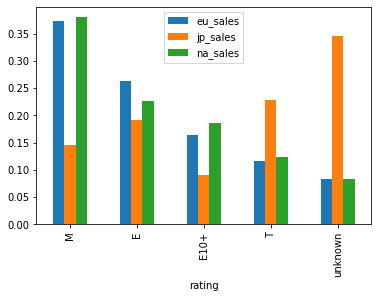

In [82]:
rating_by_region = data_act.pivot_table(index='rating',
                                        values=['na_sales',
                                                'eu_sales', 'jp_sales'],
                                        aggfunc='mean').sort_values(by='na_sales',
                                                                    ascending=False)
rating_by_region.loc[:, :] = rating_by_region.loc[:, :] / \
    rating_by_region.sum()
rating_by_region.plot(kind='bar')

In [83]:
rating_by_region

,eu_sales,jp_sales,na_sales
rating,,,
M,0.373566,0.145076,0.379937
E,0.263599,0.191227,0.225619
E10+,0.163415,0.090807,0.185970
T,0.116836,0.227760,0.124428
unknown,0.082585,0.345130,0.084047


В Европе и Америке популярность игр с различными рейтингами имеет сходную структуру - самыми популярными являются игры с рейтингом 'M' - для взрослых, затем 'E' - для всех, затем 'E10+' - для всех старше 10 лет, затем 'T' - игры для лиц от 13 и старше и, наконец, игры без рейтинга

В Японии самыми популярными являются игры без рейтинга, заетм с рейтингом 'E' - для всех, затем 'T' - для лиц старше 13, затем 'M' - для взрослых, и наконец 'E10+' - для всех старше 10. 

То есть в Европе и Америке популярны более 'взрослые' игры, а в Японии - более 'детские'. Это соотносится и с распределением популярных жанров. Также в Японии более популярны игры без рейтинга, а в Европе и Америке их доля самая маленькая.

Однако сказать, влияет ли рейтинг на продажи, или определенные игры популярны вне зависимости от рейтинга из имеющихся данных нельзя. Рейтинг ESRB обязателен только для Канады и США, поэтому возможно для игр, популярных только в Японии или имеющих отдельную японскую версию такой рейтинг не ставиться.

### Вывод

Мы составили характерные портреты пользователей из каждого региона.

Пользователь из Северной Америки чаще всего играет в игры жанра экшн на платформе Xbox 360 и предпочитает игры с рейтингом М.

Пользователь из Европы также играет в экшн, но уже на PlayStation 3 и также предпочитает игры с рейтингом М.

Пользователь из Японии играет в ролевые игры на Nintendo 3DS и чаще покупает игры без рейтинга.

## Проверка гипотез

### Сравнение рейтингов платформ Xbox One и PC

Формулируем нулевую гипотезу H₀. H₀ всегда формулируется так, чтобы использовать знак равенства. В данном случае H₀ будет звучать так:

"Средние пользовательские рейтинги платформ Xbox One и PC одинаковы"

Альтернативная гипотезу H1 для этой нулевой гипотезы на данном этапе можно сформулировать так:

"Средние пользовательские рейтинги платформ Xbox One и PC различаются."

Однако попробуем сравнить средние рейтинги по двум платформам и предположить более точную одностороннюю альтернативную гипотезу.

In [84]:
user_rating_XOne = data[data['platform'] == 'XOne']['user_score'].dropna()
user_rating_PC = data[data['platform'] == 'PC']['user_score'].dropna()

In [85]:
mean_rating_XOne = user_rating_XOne.mean()
mean_rating_PC = user_rating_PC.mean()

In [86]:
print('Средний рейтинг на Xbox One', mean_rating_XOne)
print('Средний рейтинг на PC', mean_rating_PC)

Средний рейтинг на Xbox One 6.5
Средний рейтинг на PC 7.0498611111111105


Рейтинг на платформе PC кажется больше. Сформулируем новую пару гипотез.

Гипотеза H₀:

"Средние пользовательские рейтинги платформ Xbox One и PC одинаковы"

Альтернативная гипотеза H1:

"Средние пользовательские рейтинги платформы PC больше, чем Xbox One"

Для проверки гипотез будем использовать специальный метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам.

Сравним дисперсии выборок

In [87]:
np.var(user_rating_XOne, ddof=1)

1.895906432748538

In [88]:
np.var(user_rating_PC, ddof=1)

2.4092906621851338

Дисперсии не сильно отличаются, можно оставить equal_var равным True. Пороговое значение зададим равным 5%.

In [89]:
alpha = 0.05

results = st.ttest_ind(user_rating_XOne, user_rating_PC)
print('p-значение: ', results.pvalue/2)

# pvalue делим на два, так как тест односторонний, и включаем проверку неравенства средних
if (results.pvalue/2 < alpha) and (mean_rating_PC > mean_rating_XOne):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  1.1200988121446985e-05
Отвергаем нулевую гипотезу


t-тест показал, что мы можем отвергнуть нулевую гипотезу: "Средние пользовательские рейтинги платформ Xbox One и PC одинаковы". Соответственно средний пользовательский рейтинг платформы PC больше, чем Xbox One.

### Сравнение рейтингов жанров Action и Sports

Формулируем нулевую гипотезу H₀. H₀ всегда формулируется так, чтобы использовать знак равенства. В данном случае H₀ будет звучать так:

"Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») одинаковые."

Альтернативная гипотезу H1 для этой нулевой гипотезы на данном этапе можно сформулировать так:

"Средние пользовательские рейтинги жанров Action и Sports разные."

Однако попробуем сравнить средние рейтинги по двум платформам и предположить более точную одностороннюю альтернативную гипотезу.

In [90]:
user_rating_action = data[data['genre'] == 'Action']['user_score'].dropna()
user_rating_sports = data[data['genre'] == 'Sports']['user_score'].dropna()

In [91]:
mean_rating_action = user_rating_action.mean()
mean_rating_sports = user_rating_sports.mean()

In [92]:
print('Средний рейтинг жанра Action', mean_rating_action)
print('Средний рейтинг жанра Sports', mean_rating_sports)

Средний рейтинг жанра Action 7.058931552587646
Средний рейтинг жанра Sports 6.9557692307692305


Рейтинги очень похожи, оставим двустороннюю гипотезу.

Сравним дисперсии выборок

In [93]:
np.var(user_rating_action, ddof=1)

2.027521797650873

In [94]:
np.var(user_rating_sports, ddof=1)

2.6166394627370795

Дисперсии не сильно отличаются, можно оставить equal_var равным True. Пороговое значение зададим равным 5%.

In [95]:
alpha = 0.05

results = st.ttest_ind(user_rating_action, user_rating_sports)
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.07317884722990332
Не получилось отвергнуть нулевую гипотезу


t-тест показал, что мы не можем отвергнуть нулевую гипотезу: "Средние пользовательские рейтинги жанров Action и Sports одинаковые".

### Вывод

Мы проверили две гипотезы, о равенстве средних пользовательских рейтингов платформ Xbox One и PC и о равенстве средних пользовательских рейтингов жанров Action и Sports. В первом случае нулевая гипотеза была отброшена и принята альтернативная гипотеза о том, что средний пользовательский рейтинг платформы PC больше, чем Xbox One. Во втором случае нулевая гипотеза отброшена не была.

## Общий вывод

В результате анализа мы выяснили, что наиболее перспективными на 2017 год будут игры на платформах PlayStation 4 и Xbox One(первый приоритет) и Wii U и Nintendo 3DS (второй приоритет, азиатский рынок). Самый перспективный жанр - шутер, на момент анализа игры в этом жанре были наиболее прибыльными, но по количеству они всего на четвертом месте. Игры в жанре спорт на втором месте по прибыльности, но и на третьем по количеству, а на третьем месте по прибыльности - платформеры, которых выпускается приктически меньше всех.